**Colab implementation for**
# **Accelerated MR Parameter Mapping with Scan-specific Unsupervised Networks**

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from numpy import linalg as LA
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import signal

import os

# from google.colab import drive
# drive.mount('/content/gdrive')

import time
t_prev = time.time()


In [4]:
# define necessary functions

use_cuda = torch.cuda.is_available()
print("CUDA:", use_cuda)

# data_path = '/content/gdrive/My Drive/Colab Notebooks/data/'
data_path = './data/'

# Fourier Transforms in Numpy format
def ft2_np(data):
    nx,ny = data.shape[:2]
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(data),axes=(0,1))) / np.sqrt(nx*ny)
    
def ift2_np(data):
    nx,ny = data.shape[:2]
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(data),axes=(0,1))) * np.sqrt(nx*ny)
    
def isumsq(kData):
    return np.sqrt(np.sum(np.abs(ift2_np(kData))**2,axis=2))


# Display Images
def showImg(img, name='',v_min=0, v_max=0.1,c_map='gray'):
    plt.axis('off')
#     plt.axis('equal')
    plt.tight_layout()
    if len(name) >0:
        plt.title(name)
    plt.imshow(img, cmap= c_map,vmin = v_min, vmax=v_max) 


# Display multi-contrast images 
def display_all(img):
    if img.ndim < 3:
        showImg(img)
    else:
        num_img = img.shape[2]
        num_rows = int(np.floor(np.sqrt(num_img)))
        num_cols = int(np.ceil( num_img / num_rows ))

        for k in range(num_img):
            plt.subplot(num_rows,num_cols, k+1)
            showImg(img[:,:,k])
            if k+1 == num_cols:
                plt.show()
    plt.show()


# Displaying parameter maps
def display_maps():

    showImg(abs(M0_est)*mask_T2 ,'M0',0,1.2e-1, 'jet')
    plt.colorbar()
    plt.show()

    showImg((R2_est)*mask_T2,'R2',0, 1.5e-2,'jet')
    plt.colorbar()
    plt.show()

    showImg((T2_est)*mask_T2,'T2',0, 120,'jet')
    plt.colorbar()
    plt.show()


CUDA: False


Gold Standard Images


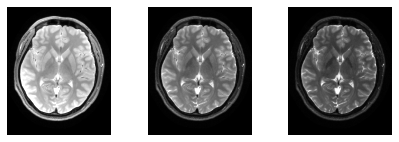

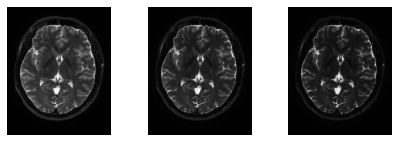

In [5]:
# loading the data

echo_use_idx = np.arange(1,17,3)


# coil size: [nx ny nc] = [208 256 12]
coil_sens = sio.loadmat(data_path + 'T2_DATA.mat')['sens']
coil_sens = coil_sens[:,:,:,None]

# kData size: [nx ny nc ne] = [208 256 12 32]
kData = sio.loadmat(data_path+'T2_DATA.mat')['kData']
nx, ny, nc, ne = kData.shape

# Echo time
TE_use = np.arange(23,200,34.5) 


mask_T2 = sio.loadmat(data_path + 'T2_DATA.mat')['mask_T2']

# Gold standard
ideal = (coil_sens.conj()*ift2_np( kData )).sum(2) / ((abs(coil_sens)**2).sum(2)+np.finfo(float).eps);

# Displaying gold standard images
print("Gold Standard Images")
display_all(abs(ideal))


In [6]:
# Sampling Mask (5x acceleration mask)
step = 5
kMask = np.zeros((nx,ny,nc,ne),dtype=bool)
# kMask[:,::step,:] = 1
delta_k = np.arange(ne) % step

for t in range(ne):
    kMask[:,delta_k[t]::step,:,t] = 1

acc = np.prod(kMask.shape) / kMask.sum()

print('Acc: ' + str(acc) + 'x')

mask = torch.tensor(kMask.transpose(2,3,0,1))[None,...,None]
if use_cuda:
    mask = mask.cuda()

# display_all(kMask[:,:,0,:])

Acc: 4.992x


In [7]:
# pytorch form data and functions

coilc = torch.tensor(coil_sens.transpose(2,3,0,1),dtype = torch.cfloat) 
datc = torch.tensor((kData*kMask).transpose(2,3,0,1),dtype=torch.cfloat)[None,:,:,:,:]
maskc = torch.tensor(kMask.transpose(2,3,0,1))[None,...]


if use_cuda:
    coilc, datc, maskc = coilc.cuda(), datc.cuda(), maskc.cuda()

# Fourier transforms in torch tensor format
def ft2c(x):
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(x), dim = (-1,-2), norm = "ortho"))

def ift2c(x):
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(x), dim = (-1,-2), norm = "ortho"))

# SENSE forward model and its Hermitian adjoint
def Ac(x):
    return maskc * ft2c(coilc * x[:,None,...])

def Ahc(x):
    return (torch.conj(coilc)*ift2c(maskc*x)).sum(1)

# Inner product
def inner_c(x,y):
    return (torch.conj(x) * y).sum(list(range(1,x.dim())) )

# Loss functions
MSE = nn.MSELoss()
L1 = nn.L1Loss()

# MSE loss for complex data
def MSEc(x, y):
    return MSE(torch.view_as_real(x), torch.view_as_real(y))

In [8]:
# T2 relaxation signal model
TEs = torch.tensor(TE_use[None,None,:]).float()

if use_cuda:
    TEs = TEs.cuda()
    
class T2_Relaxation(nn.Module):
    def __init__(self):
        super(T2_Relaxation, self).__init__()
        self.M0 = nn.Parameter(torch.rand(nx,ny,1,2)*1e-2)
        self.R2 = nn.Parameter(torch.rand(nx,ny,1)*1e-2)
         
    def forward(self):
        return torch.view_as_complex(self.M0) * torch.exp(-self.R2 * TEs)


In [ ]:
# Gold Standard parameter maps (Least-squares fitting)
target = torch.tensor(ideal,dtype = torch.cfloat)

model_param = T2_Relaxation()

if use_cuda:
    model_param, target = model_param.cuda(), target.cuda()

criterion = nn.MSELoss()

Adam_lr = 1e-3
optimizer = optim.Adam(model_param.parameters(), lr=Adam_lr)

for k in range(5000):
    optimizer.zero_grad()
    a = model_param()
    loss = MSEc(a, target)
    if (k+1)%500 == 0:
        print('iter', k+1, 'train loss: ' + str(loss.cpu().detach().numpy()))

    loss.backward()
    optimizer.step()


In [ ]:
# Displaying Gold Standard Parameter Maps
M0_est = torch.view_as_complex(model_param.M0.detach()).squeeze()
if use_cuda:
    M0_est = M0_est.cpu()
M0_est = M0_est.numpy()

R2_est = model_param.R2.detach().squeeze()
if use_cuda:
    R2_est = R2_est.cpu()
R2_est = R2_est.numpy()

T2_est = 1/R2_est

print("Gold Standard Parameter Maps")
display_maps()



iter 1 residue 1.0120996
iter 2 residue 0.5433765
iter 3 residue 0.2686235
iter 4 residue 0.27464616
iter 5 residue 0.17062408
iter 6 residue 0.14612828
iter 7 residue 0.093302354
iter 8 residue 0.09619282
iter 9 residue 0.09528285
iter 10 residue 0.07465709
iter 11 residue 0.07007955
iter 12 residue 0.06104554
iter 13 residue 0.061668165
iter 14 residue 0.06126037
iter 15 residue 0.04934194
iter 16 residue 0.053448923
iter 17 residue 0.031012507
iter 18 residue 0.033899415
iter 19 residue 0.024987914
iter 20 residue 0.030031694
iter 21 residue 0.028018847
iter 22 residue 0.02342788
iter 23 residue 0.026677419
iter 24 residue 0.02108758
iter 25 residue 0.025234096
iter 26 residue 0.022666106
iter 27 residue 0.022070762
iter 28 residue 0.024136743
iter 29 residue 0.018174753
iter 30 residue 0.018806295
iter 31 residue 0.013566343
iter 32 residue 0.014076014
iter 33 residue 0.014283076
iter 34 residue 0.0135285845
iter 35 residue 0.015144247
iter 36 residue 0.012645263
iter 37 residue 0.

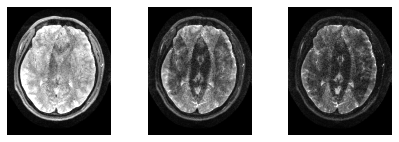

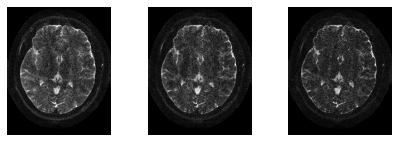

In [9]:
# CG-SENSE Reconstruction

x = Ahc(datc) 
if use_cuda:
    x = x.cuda()


r = Ahc(datc) - Ahc(Ac(x))
p = r
rsold = torch.norm(r, 'fro') **2
# rsold = inner_c(r,r)

max_iter = 50


for it in range(max_iter):
    z = Ahc(Ac(p))
    alpha = rsold / inner_c(p, z)
    x = x + alpha * p
    r = r - alpha * z
    rsnew = torch.norm(r, 'fro')**2

    print('iter', it+1, 'residue', torch.sqrt(rsnew).cpu().numpy()) 

    if torch.sqrt(rsnew) < 1e-4:
        break
    p = r + (rsnew / rsold) * p
    rsold = rsnew

sense_tensor = x

recon = x.squeeze()


if use_cuda:
    recon = recon.cpu()



recon = recon.numpy().transpose(1,2,0)
sense = recon

print()
print("SENSE Reconstruction")
display_all(abs(recon))


In [10]:
# SENSE parameter maps
target = torch.tensor(sense,dtype = torch.cfloat)

model_param = T2_Relaxation()

if use_cuda:
    model_param, target = model_param.cuda(), target.cuda()

criterion = nn.MSELoss()

Adam_lr = 1e-3
optimizer = optim.Adam(model_param.parameters(), lr=Adam_lr)

for k in range(5000):
    optimizer.zero_grad()
    a = model_param()

    loss = MSEc(a, target)
    if (k+1)%500 == 0:
        print('iter', k+1, 'train loss: ' + str(loss.cpu().detach().numpy()))

    loss.backward()
    optimizer.step()


iter 500 train loss: 5.0027582e-05
iter 1000 train loss: 4.978042e-05
iter 1500 train loss: 4.972585e-05
iter 2000 train loss: 4.9693004e-05
iter 2500 train loss: 4.9684208e-05
iter 3000 train loss: 4.96723e-05
iter 3500 train loss: 4.966618e-05
iter 4000 train loss: 4.965962e-05
iter 4500 train loss: 4.9651826e-05
iter 5000 train loss: 4.9659546e-05


SENSE parameter maps


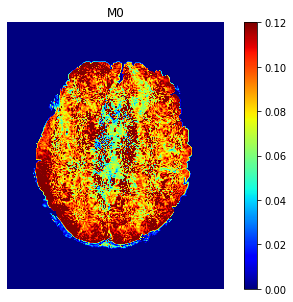

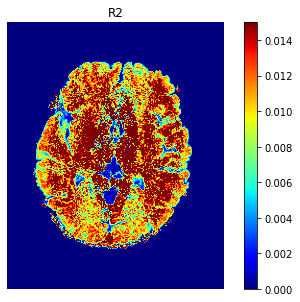

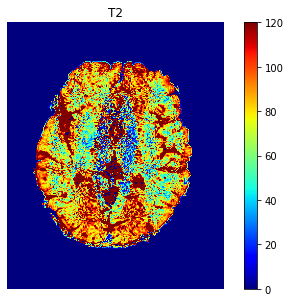

NRMSE: 0.2725058881854775


In [11]:
# Display Parameter Maps
M0_est = torch.view_as_complex(model_param.M0.detach()).squeeze()
if use_cuda:
    M0_est = M0_est.cpu()
M0_est = M0_est.numpy()

R2_est = model_param.R2.detach().squeeze()
if use_cuda:
    R2_est = R2_est.cpu()
R2_est = R2_est.numpy()

T2_est = 1/R2_est


print("SENSE parameter maps")
display_maps()


# Generate images from M0 and T2
gen_img = model_param().detach().cpu().numpy()
# display_all(abs(gen_img))

bNRMSE = LA.norm( mask_T2[:,:,None]*(ideal - gen_img)) / LA.norm(mask_T2[:,:,None]*(ideal))

print("NRMSE:", bNRMSE)

iter 200 train loss: 0.00023750853
iter 400 train loss: 0.00018650762
iter 600 train loss: 0.00018072105
iter 800 train loss: 0.00017905759
iter 1000 train loss: 0.0001783569

Proposed Method - Parameter Maps with SENSE Reconstruction


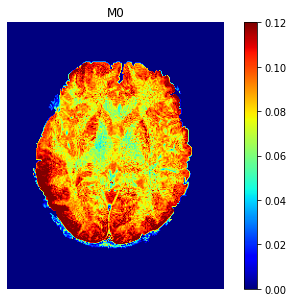

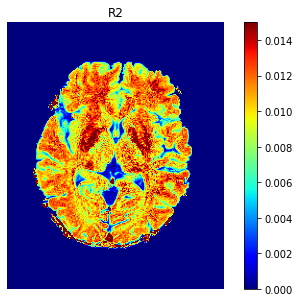

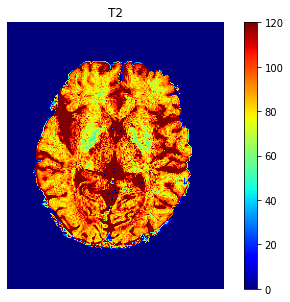

NRMSE: 0.10002814314625609


In [12]:
# Proposed Method - parameter maps with SENSE reconstruction

target = torch.tensor(sense,dtype = torch.cfloat)

signal_model = T2_Relaxation()

if use_cuda:
    signal_model, target = signal_model.cuda(), target.cuda()

Adam_lr = 1e-3
optimizer = optim.Adam(signal_model.parameters(), lr=Adam_lr)

for k in range(1000):
    optimizer.zero_grad()
    a = signal_model()
    loss1 = MSEc(a, target)
    loss2 = MSEc(Ac(a.permute(2,0,1)[None]), datc)
    loss = loss1 + 1e3*loss2
    if (k+1)%200 == 0:
        print('iter', k+1, 'train loss: ' + str(loss.cpu().detach().numpy()))

    loss.backward()
    optimizer.step()


M0_est = torch.view_as_complex(signal_model.M0.detach()).squeeze()
if use_cuda:
    M0_est = M0_est.cpu()
M0_est = M0_est.numpy()


R2_est = signal_model.R2.detach().squeeze()
if use_cuda:
    R2_est = R2_est.cpu()
R2_est = R2_est.numpy()

T2_est = 1/R2_est


# Display Parameter Maps
print("\nProposed Method - Parameter Maps with SENSE Reconstruction")
display_maps()


# NRMSE computation
gen_img = signal_model().detach().cpu().numpy()
bNRMSE = LA.norm( mask_T2[:,:,None]*(ideal - gen_img)) / LA.norm(mask_T2[:,:,None]*(ideal))
print("NRMSE:", bNRMSE)



In [13]:
# Necessary module blocks for LORAKI regularization

def Bc(x):
    return torch.view_as_real(ft2c(x))

def Bhc(x):
    return ift2c(torch.view_as_complex(x))

def D(x):
    return torch.cat((x[...,0], x[...,1]),dim=1)
def Dh(x):
    idx = x.shape[1]
    return torch.stack((x[:,:idx//2], x[:,idx//2:]), dim=-1)

def VCC_aug(data):
    return torch.cat((data, conj(torch.flip(data,[-3,-2]))), dim = 1)

def VCC_aug_H(data):
    idx = data.shape[1]
    return data[:,:idx//2] + conj(torch.flip(data[:,idx//2:],[-3,-2]))


VCC= False
nf = 64
ker_size = 7

# define convolution layers
class Conv_Layers(nn.Module):
    def __init__(self):
        super(Conv_Layers, self).__init__()
    
        self.conv1 = nn.Conv2d((2+2*VCC)*ne , nf, kernel_size=(ker_size, ker_size), padding=(ker_size//2,ker_size//2), bias=False)#, stride=step)
        self.conv2 = nn.Conv2d(nf, (2+2*VCC)*ne, kernel_size=(ker_size, ker_size), padding=(ker_size//2,ker_size//2), bias=False)#, stride=step)

        torch.nn.init.xavier_uniform_(self.conv1.weight, gain=0.1)
        torch.nn.init.xavier_uniform_(self.conv2.weight, gain=0.1)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return x    

In [18]:
# LORAKI reconstruction
def SENSE_LORAKI(Ahd,model,optimizer,target=None,mu=1.,max_epoch=500,max_iter=7,disp_period=10,bmask=mask_T2[:,:,None],TV=False,mu_TV=1.,VCC=False):

    t_start = time.time()
    train_input = Ahd 

    for epoch in range(max_epoch+1):

        # Training stage    
        model.train()
        ave_loss = 0.
        optimizer.zero_grad()
        x = train_input

        if use_cuda:
            x, Ahd = x.cuda(), Ahd.cuda()

        # Taking Conjugate Gradient for SENSE-LORAKI
        if VCC:
            r = Ahd - (Ahc(Ac(x)) + 0.5*Bhc(VCC_aug_H(Dh(model(D(VCC_aug(Bc(x))))))))
        else:
            r = Ahd - (Ahc(Ac(x)) + Bhc(Dh(model(D(Bc(x))))))

        p = r    
        rsold = torch.norm(r, 'fro') **2

        for it in range(max_iter):
            if VCC:
                z = Ahc(Ac(p)) + 0.5*Bhc(VCC_aug_H(Dh(model(D(VCC_aug(Bc(p)))))))
            else:
                z = Ahc(Ac(p)) + Bhc(Dh(model(D(Bc(p)))))
            alpha = rsold / inner_c(p, z)
            x = x + alpha * p
            r = r - alpha * z
            rsnew = torch.norm(r, 'fro') **2

            p = r + (rsnew / rsold) * p
            rsold = rsnew
       
        if target is not None:
            a1 = L1(x ,target)
        
        # loss function 
        a2 = L1(Ac(x) , datc)

        # spatial difference in x, y direction, respectively (for TV regularization) (if necessary)
        if TV:
            a3 = L1(torch.roll(x, shifts=(-1, 0), dims=(-2, -1)), x) 
            a4 = L1(torch.roll(x, shifts=(0, -1), dims=(-2, -1)), x) 
            
        loss = a2 

        if target is not None:
            loss = a1 + mu * loss 
        if TV:
            loss = loss + mu_TV * (a3 + a4)

        loss.backward()
        optimizer.step()
            
        if (epoch) % disp_period == 0:
            print(' LORAKI training epoch: %d, train_loss: %.10f' %(epoch, loss))
        
    t_end = time.time()
    return np.squeeze(x.cpu().detach().numpy().transpose(0,2,3,1)), (t_end-t_start)

In [19]:
# Parameter estimation with the proposed framework
def param_est(target,signal_model,optimizer,mu=1e3,max_epoch=3000,TV=False,mu_TV=1e-2):

    for k in range(max_epoch+1):
        optimizer.zero_grad()
        a = signal_model()

        loss1 = MSEc(a, target)
        loss2 = MSEc(Ac(a.permute(2,0,1)[None]), datc)

        loss = loss1 + mu*loss2

        if TV:
            l3 = L1(torch.roll(a, shifts=(-1, 0), dims=(-3, -2)), a) 
            l4 = L1(torch.roll(a, shifts=(0, -1), dims=(-3, -2)), a) 
            loss = loss + mu_TV*(l3 + l4)

        loss.backward()
        optimizer.step()
        
        if k%500 == 0:
            print(' Train loss: ' + str(loss.cpu().detach().numpy()))


    M0_est = torch.view_as_complex(signal_model.M0.detach()).squeeze()
    if use_cuda:
        M0_est = M0_est.cpu()
    M0_est = M0_est.numpy()


    R2_est = signal_model.R2.detach().squeeze()
    if use_cuda:
        R2_est = R2_est.cpu()
    R2_est = R2_est.numpy()


    gen_img = (signal_model().detach()).cpu().numpy()

    return M0_est, R2_est, (1/R2_est), gen_img

In [20]:
# Proposed MR Parameter mapping with LORAKI reconstruction

loraki_lr = 1e-4
param_lr = 1e-3


# LORAKI initialization
Ahd = Ahc(datc)
new_target = None

max_iter = 2

for it in range(max_iter):
#Phase 1: LORAKI Recon
    print("Phase 1: LORAKI Recon", it )
    model_loraki = Conv_Layers()
    if use_cuda:
        model_loraki = model_loraki.cuda()

    optim_loraki = optim.Adam(model_loraki.parameters(), lr=loraki_lr)
    loraki,time_loraki = SENSE_LORAKI(Ahd,model_loraki,optim_loraki,max_epoch=700,target=new_target,disp_period=100)

#Phase 2: Parameter Estimation
    print("Phase 2: Parameter Estimation", it )
    target = torch.tensor(loraki,dtype=torch.cfloat)
    signal_model = T2_Relaxation()
    if use_cuda:
        signal_model, target = signal_model.cuda(), target.cuda()

    optim_param = optim.Adam(signal_model.parameters(), lr=param_lr)

    # Parameter estimation using LORAKI recon
    M0_est, R2_est, T2_est, gen_img = param_est(target, signal_model,optim_param, mu = 1e3/(10**it))

    # setting up new target
    new_target = torch.tensor(gen_img).permute(2,0,1)[None]
    if use_cuda:
        new_target = new_target.cuda()
    print()



Phase 1: LORAKI Recon 0
 LORAKI training epoch: 0, train_loss: 0.0001632682
 LORAKI training epoch: 100, train_loss: 0.0001547588
 LORAKI training epoch: 200, train_loss: 0.0001534152
 LORAKI training epoch: 300, train_loss: 0.0001529700
 LORAKI training epoch: 400, train_loss: 0.0001526088
 LORAKI training epoch: 500, train_loss: 0.0001524200
 LORAKI training epoch: 600, train_loss: 0.0001522111
 LORAKI training epoch: 700, train_loss: 0.0001520794
Phase 2: Parameter Estimation 0
 Train loss: 0.0075616827
 Train loss: 0.00012446886
 Train loss: 0.000120624776
 Train loss: 0.00011998029
 Train loss: 0.000119698496
 Train loss: 0.000119501296
 Train loss: 0.00011936089

Phase 1: LORAKI Recon 1
 LORAKI training epoch: 0, train_loss: 0.0124058733
 LORAKI training epoch: 100, train_loss: 0.0031365976
 LORAKI training epoch: 200, train_loss: 0.0027029167
 LORAKI training epoch: 300, train_loss: 0.0024997240
 LORAKI training epoch: 400, train_loss: 0.0023708097
 LORAKI training epoch: 500, t

Proposed Method - Parameter Maps with LORAKI Reconstruction


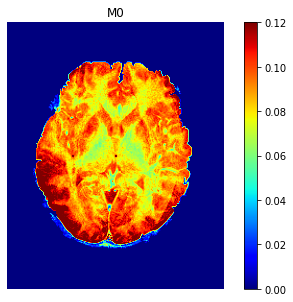

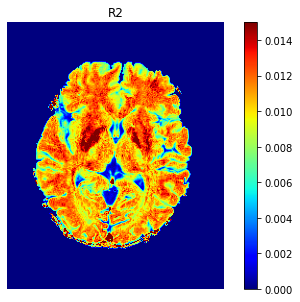

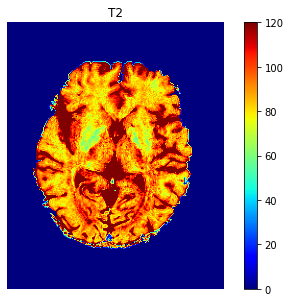

NRMSE: 0.07424368672984559


In [21]:
# Display results
bNRMSE = LA.norm( mask_T2[:,:,None]*(ideal - gen_img)) / LA.norm(mask_T2[:,:,None]*(ideal))

print("Proposed Method - Parameter Maps with LORAKI Reconstruction")
display_maps()
print("NRMSE:", bNRMSE)